In [35]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up credentials
GEE_JSON = os.getenv("GEE_JSON")
PROJECT = os.getenv("PROJECT")
EXPORT_BUCKET = os.getenv("GEE_BUCKET")
EXPORT_PREFIX = "landscape_indicators_20230921"

DATA_FOLDER = "../data/raw"

In [10]:
country_stats = pd.read_csv(f"gs://{EXPORT_BUCKET}/{EXPORT_PREFIX}/country_stats_100m.csv")
country_kernel_stats = pd.read_csv(
    f"gs://{EXPORT_BUCKET}/{EXPORT_PREFIX}/sluc_kernel_country_stats_1000m.csv"
)
country_stats.set_index("ADM0_CODE", inplace=True)
country_kernel_stats.set_index("ADM0_CODE", inplace=True)
country_stats = country_stats.join(country_kernel_stats, rsuffix="2")
print(country_stats.columns)
country_stats.head()

Index(['system:index', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR', 'STATUS',
       'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'const', 'cropland',
       'deforest', 'deforest_carbon', 'dluc_cropland_deforest',
       'dluc_cropland_deforest_carbon', 'dluc_cropland_nattreeloss',
       'dluc_cropland_treeloss', 'dluc_nonnat_deforest',
       'dluc_nonnat_deforest_carbon', 'dluc_nonnat_nattreeloss',
       'dluc_nonnat_treeloss', 'nat_treeloss', 'nonnat', 'treeloss', '.geo',
       'system:index2', 'ADM0_NAME2', 'DISP_AREA2', 'EXP0_YEAR2', 'STATUS2',
       'STR0_YEAR2', 'Shape_Area2', 'Shape_Leng2', 'const2',
       'cropland_deforest_by_human_lu_0km_1000m',
       'cropland_deforest_by_human_lu_10km_1000m',
       'cropland_deforest_by_human_lu_25km_1000m',
       'cropland_deforest_by_human_lu_50km_1000m',
       'cropland_deforest_by_human_lu_5km_1000m',
       'cropland_deforest_carbon_by_human_lu_0km_1000m',
       'cropland_deforest_carbon_by_human_lu_10km_1000m',
       'cropland_defo

,system:index,ADM0_NAME,DISP_AREA,EXP0_YEAR,STATUS,STR0_YEAR,Shape_Area,Shape_Leng,const,cropland,...,nonnat_natural_crop_net_conversion_by_human_lu_10km_1000m,nonnat_natural_crop_net_conversion_by_human_lu_25km_1000m,nonnat_natural_crop_net_conversion_by_human_lu_50km_1000m,nonnat_natural_crop_net_conversion_by_human_lu_5km_1000m,nonnat_tree_loss_by_human_lu_0km_1000m,nonnat_tree_loss_by_human_lu_10km_1000m,nonnat_tree_loss_by_human_lu_25km_1000m,nonnat_tree_loss_by_human_lu_50km_1000m,nonnat_tree_loss_by_human_lu_5km_1000m,.geo2
ADM0_CODE,,,,,,,,,,,,,,,,,,,,,
1,00000000000000000029,Afghanistan,NO,3000,Member State,1000,62.554886,58.988002,6.418374e+05,28103.062837,...,252.812782,249.434493,258.646991,247.799409,1.178819,0.926596,0.962920,1.304262,0.945994,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,00000000000000000012,Aksai Chin,YES,3000,Sovereignty unsettled,1000,3.028950,10.774006,3.066542e+04,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000083,0.000060,0.000147,0.000103,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,00000000000000000067,Albania,NO,3000,Member State,1000,3.076365,13.494287,2.868165e+04,2001.537786,...,5.416760,3.335665,2.074649,7.490282,18.090614,23.885509,25.292438,24.989412,21.702992,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,000000000000000000a5,Algeria,NO,3000,Member State,1000,212.693097,81.248391,2.308743e+06,52583.702468,...,432.424044,430.955615,409.939208,435.046049,61.456965,110.267648,128.000490,119.097907,94.071457,"{""type"":""MultiPoint"",""coordinates"":[]}"
5,00010000000000000018,American Samoa,NO,3000,US Non-Self-Governing Territory,1000,0.016747,2.011719,1.999620e+02,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [3]:
# Load FAO data

country_df = pd.read_csv(f"{DATA_FOLDER}/country-codes.csv")
fao_forest_data = pd.read_csv(
    f"{DATA_FOLDER}/Emissions_Land_Use_Forests_E_All_Data_(Normalized).csv", encoding="latin-1"
)
fao_landuse_data = pd.read_csv(
    f"{DATA_FOLDER}/Inputs_LandUse_E_All_Data_(Normalized).csv", encoding="latin-1"
)

fao_forest_data = fao_forest_data[
    ((fao_forest_data["Year"] <= 2022) & (fao_forest_data["Year"] > 2002))
]
fao_forest_data["M49"] = fao_forest_data["Area Code (M49)"].apply(lambda x: x[1:]).astype(float)
fao_landuse_data = fao_landuse_data[
    ((fao_landuse_data["Year"] <= 2022) & (fao_landuse_data["Year"] > 2002))
]
fao_landuse_data["M49"] = fao_landuse_data["Area Code (M49)"].apply(lambda x: x[1:]).astype(float)

fao_area = (
    fao_forest_data[
        (
            (fao_forest_data["Source"] == "FAO TIER 1")
            & (fao_forest_data["Item"] == "Net Forest conversion")
            & (fao_forest_data["Element"] == "Area")
        )
    ]
    .groupby("M49")["Value"]
    .mean()
    * 10
)  # convert to km2
fao_area.name = "fao_forestloss"

fao_emissions = (
    fao_forest_data[
        (
            (fao_forest_data["Source"] == "FAO TIER 1")
            & (fao_forest_data["Item"] == "Net Forest conversion")
            & (fao_forest_data["Element"] == "Net emissions/removals (CO2) (Forest land)")
        )
    ]
    .groupby("M49")["Value"]
    .mean()
    * 1000
    # kT to tons
)
fao_emissions.name = "fao_emissions"

fao_cropland = (
    fao_landuse_data[((fao_landuse_data["Item"] == "Cropland"))].groupby("M49")["Value"].mean() * 10
)  # convert to km2
fao_cropland.name = "fao_cropland"

fao_agland = (
    fao_landuse_data[((fao_landuse_data["Item"] == "Agricultural land"))]
    .groupby("M49")["Value"]
    .mean()
    * 10
)  # convert to km2
fao_agland.name = "fao_agland"

all_fao = pd.concat([fao_area, fao_emissions, fao_cropland, fao_agland], axis=1)
all_fao.head()

,fao_forestloss,fao_emissions,fao_cropland,fao_agland
M49,,,,
1.0,111438.292111,3.376843e+09,3.851482e+06,2.396757e+07
2.0,38708.883556,1.048339e+09,6.722308e+05,5.677998e+06
4.0,0.000000,0.000000e+00,1.992586e+04,1.901139e+05
5.0,44025.451111,1.616329e+09,3.243051e+05,2.685559e+06
8.0,0.000000,0.000000e+00,1.949781e+03,6.024428e+03


In [4]:
c = country_df.drop(211)
c.GAUL = c.GAUL.astype(float)
c = c.filter(["GAUL", "CLDR display name", "Sub-region Name", "M49"])
c.rename(columns={"CLDR display name": "country_name", "Sub-region Name": "region"}, inplace=True)

all_stats = (
    country_stats.groupby("ADM0_CODE").sum().join(c.set_index("GAUL")).join(all_fao, on="M49")
)

all_stats["deforest_carbon"] *= 100 * 3.66  # ha->km2 and tC -> tCO2e
all_stats["nonnat_deforest_carbon_by_human_lu_0km_1000m"] *= 100  # ha->km2
all_stats["nonnat_deforest_carbon_by_human_lu_5km_1000m"] *= 100  # ha->km2
all_stats["nonnat_deforest_carbon_by_human_lu_10km_1000m"] *= 100  # ha->km2
all_stats["nonnat_deforest_carbon_by_human_lu_25km_1000m"] *= 100  # ha->km2
all_stats["nonnat_deforest_carbon_by_human_lu_50km_1000m"] *= 100  # ha->km2
all_stats["cropland_deforest_carbon_by_human_lu_0km_1000m"] *= 100  # ha->km2
all_stats["cropland_deforest_carbon_by_human_lu_5km_1000m"] *= 100  # ha->km2
all_stats["cropland_deforest_carbon_by_human_lu_10km_1000m"] *= 100  # ha->km2
all_stats["cropland_deforest_carbon_by_human_lu_25km_1000m"] *= 100  # ha->km2
all_stats["cropland_deforest_carbon_by_human_lu_50km_1000m"] *= 100  # ha->km2

# annualize
all_stats["sluc_treeloss_nonnat_ha"] = all_stats["treeloss"] / all_stats["nonnat"]
all_stats["sluc_treeloss_cropland_ha"] = all_stats["treeloss"] / all_stats["cropland"]
all_stats["sluc_treeloss_cropland"] = all_stats["cropland"] * all_stats["sluc_treeloss_nonnat_ha"]
all_stats["sluc_nat_treeloss_nonnat_ha"] = all_stats["nat_treeloss"] / all_stats["nonnat"]
all_stats["sluc_nat_treeloss_cropland_ha"] = all_stats["nat_treeloss"] / all_stats["cropland"]
all_stats["sluc_nat_treeloss_cropland"] = (
    all_stats["cropland"] * all_stats["sluc_nat_treeloss_nonnat_ha"]
)
all_stats["sluc_deforest_nonnat_ha"] = all_stats["deforest"] / all_stats["nonnat"]
all_stats["sluc_deforest_cropland_ha"] = all_stats["deforest"] / all_stats["cropland"]
all_stats["sluc_deforest_cropland"] = all_stats["cropland"] * all_stats["sluc_deforest_nonnat_ha"]
all_stats["sluc_deforest_carbon_nonnat_ha"] = all_stats["deforest_carbon"] / all_stats["nonnat"]
all_stats["sluc_deforest_carbon_cropland_ha"] = all_stats["deforest_carbon"] / all_stats["cropland"]
all_stats["sluc_deforest_carbon_cropland"] = (
    all_stats["cropland"] * all_stats["sluc_deforest_carbon_nonnat_ha"]
)
all_stats["sluc_fao_agland_ha"] = all_stats["fao_forestloss"] / all_stats["fao_agland"]
all_stats["sluc_fao_cropland_ha"] = all_stats["fao_forestloss"] / all_stats["fao_cropland"]
all_stats["sluc_fao_cropland"] = all_stats["fao_cropland"] * all_stats["sluc_fao_agland_ha"]
all_stats["sluc_emissions_fao_agland_ha"] = all_stats["fao_emissions"] / all_stats["fao_agland"]
all_stats["sluc_emissions_fao_cropland_ha"] = all_stats["fao_emissions"] / all_stats["fao_cropland"]
all_stats["sluc_emissions_fao_cropland"] = (
    all_stats["fao_cropland"] * all_stats["sluc_emissions_fao_agland_ha"]
)

print(all_stats.columns)
all_stats.to_csv("../data/processed/sluc_vs_dluc_stats.csv")
all_stats.head()

Index(['system:index', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR', 'STATUS',
       'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'const', 'cropland',
       'deforest', 'deforest_carbon', 'dluc_cropland_deforest',
       'dluc_cropland_deforest_carbon', 'dluc_cropland_nattreeloss',
       'dluc_cropland_treeloss', 'dluc_nonnat_deforest',
       'dluc_nonnat_deforest_carbon', 'dluc_nonnat_nattreeloss',
       'dluc_nonnat_treeloss', 'nat_treeloss', 'nonnat', 'treeloss', '.geo',
       'system:index2', 'ADM0_NAME2', 'DISP_AREA2', 'EXP0_YEAR2', 'STATUS2',
       'STR0_YEAR2', 'Shape_Area2', 'Shape_Leng2', 'const2',
       'cropland_deforest_by_human_lu_0km_1000m',
       'cropland_deforest_by_human_lu_10km_1000m',
       'cropland_deforest_by_human_lu_25km_1000m',
       'cropland_deforest_by_human_lu_50km_1000m',
       'cropland_deforest_by_human_lu_5km_1000m',
       'cropland_deforest_carbon_by_human_lu_0km_1000m',
       'cropland_deforest_carbon_by_human_lu_10km_1000m',
       'cropland_defo

,system:index,ADM0_NAME,DISP_AREA,EXP0_YEAR,STATUS,STR0_YEAR,Shape_Area,Shape_Leng,const,cropland,...,sluc_deforest_cropland,sluc_deforest_carbon_nonnat_ha,sluc_deforest_carbon_cropland_ha,sluc_deforest_carbon_cropland,sluc_fao_agland_ha,sluc_fao_cropland_ha,sluc_fao_cropland,sluc_emissions_fao_agland_ha,sluc_emissions_fao_cropland_ha,sluc_emissions_fao_cropland
ADM0_CODE,,,,,,,,,,,,,,,,,,,,,
1.0,00000000000000000029,Afghanistan,NO,3000,Member State,1000,62.554886,58.988002,6.418374e+05,28103.062837,...,0.073256,0.015173,0.046839,426.405461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,00000000000000000012,Aksai Chin,YES,3000,Sovereignty unsettled,1000,3.028950,10.774006,3.066542e+04,0.000000,...,0.000000,0.205093,inf,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3.0,00000000000000000067,Albania,NO,3000,Member State,1000,3.076365,13.494287,2.868165e+04,2001.537786,...,1.740409,17.039273,55.946439,34104.748068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4.0,000000000000000000a5,Algeria,NO,3000,Member State,1000,212.693097,81.248391,2.308743e+06,52583.702468,...,12.861472,3.555319,6.578726,186951.845670,0.000178,0.001737,3.751314,1.230603,12.028345,25981.181100
5.0,00010000000000000018,American Samoa,NO,3000,US Non-Self-Governing Territory,1000,0.016747,2.011719,1.999620e+02,0.000000,...,0.000000,0.000000,NaN,0.000000,0.003802,0.001036,1.101049,108.777003,29.638200,31499.188021


In [5]:
c.region.unique()

array([nan, 'Southern Asia', 'Southern Europe', 'Northern Africa',
       'Polynesia', 'Sub-Saharan Africa',
       'Latin America and the Caribbean', 'Western Asia',
       'Australia and New Zealand', 'Western Europe', 'Eastern Europe',
       'Northern America', 'South-eastern Asia', 'Eastern Asia',
       'Northern Europe', 'Melanesia', 'Micronesia', 'Central Asia'],
      dtype=object)

/Users/fgassert/Documents/git/lg_landscape_indicators/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/fgassert/Documents/git/lg_landscape_indicators/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: title={'center': 'Forest loss area (km2) / yr'}, xlabel='Country'>

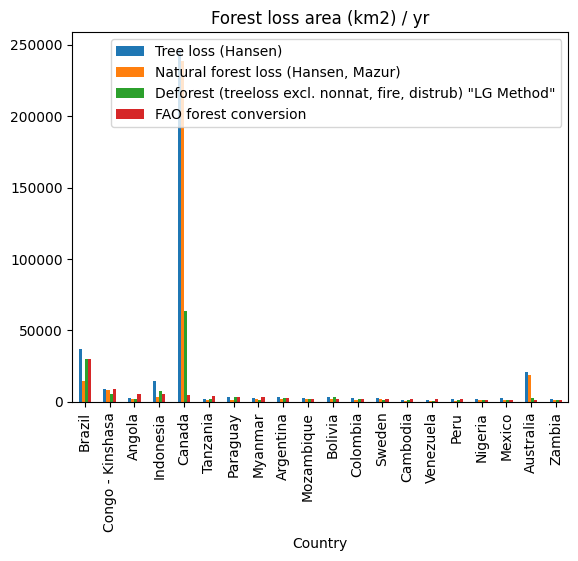

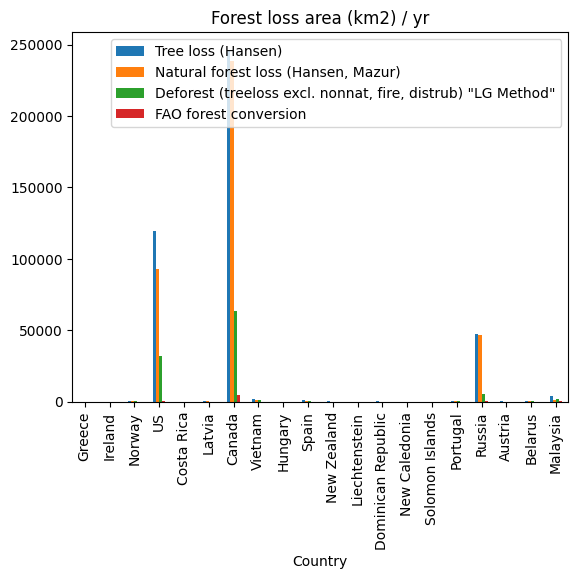

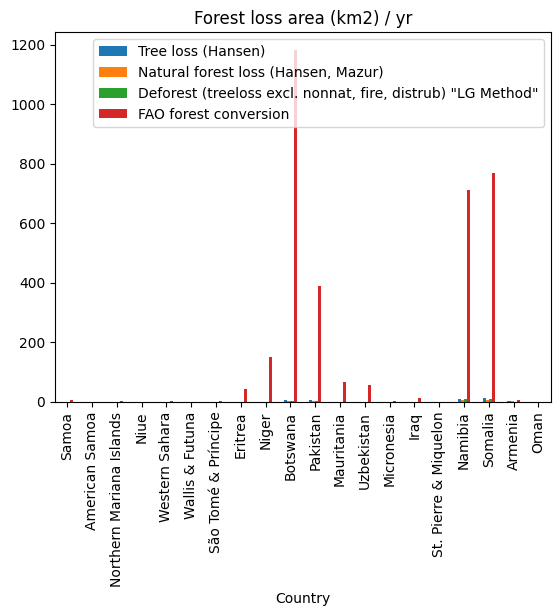

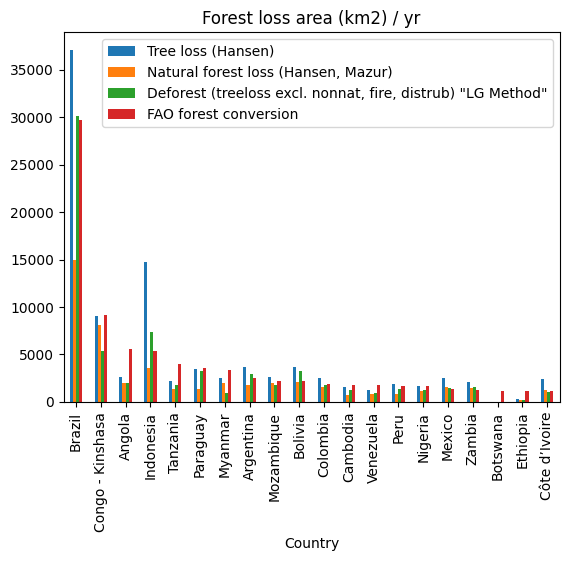

In [43]:
# Comparison of deforestation definitions
N = 20
SORT_COL = "fao_forestloss"
title = "Forest loss area (km2) / yr"
cols = {
    "country_name": "Country",
    "treeloss": "Tree loss (Hansen)",
    "nat_treeloss": "Natural forest loss (Hansen, Mazur)",
    "deforest": 'Deforest (treeloss excl. nonnat, fire, distrub) "LG Method"',
    "fao_forestloss": "FAO forest conversion",
}
all_stats.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.bar(x="Country", title=title)

all_stats["fao_ratio"] = np.log(all_stats["deforest"] / all_stats["fao_forestloss"])
all_stats[all_stats["fao_forestloss"] > 0].sort_values("fao_ratio", ascending=False).head(N).filter(
    cols.keys()
).rename(columns=cols).plot.bar(x="Country", title=title)
all_stats["fao_ratio"] = np.log(all_stats["deforest"] / all_stats["fao_forestloss"])
all_stats[all_stats["fao_forestloss"] > 0].sort_values("fao_ratio").head(N).filter(
    cols.keys()
).rename(columns=cols).plot.bar(x="Country", title=title)


REGION_LIST = [
    "Southern Asia",  #'Southern Europe', 'Northern Africa',
    "Polynesia",
    "Sub-Saharan Africa",
    "Latin America and the Caribbean",  #'Western Asia',
    #'Australia and New Zealand', 'Western Europe', 'Eastern Europe',
    #'Northern America',
    "South-eastern Asia",
    "Eastern Asia",
    #'Northern Europe',
    "Melanesia",
    "Micronesia",  #'Central Asia'
]
all_stats_trop = all_stats[all_stats.region.isin(REGION_LIST)]
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.bar(x="Country", title=title)

/var/folders/dy/fpsjfhd97fbfjcd25y_m3_8m0000gn/T/ipykernel_50334/1630371954.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


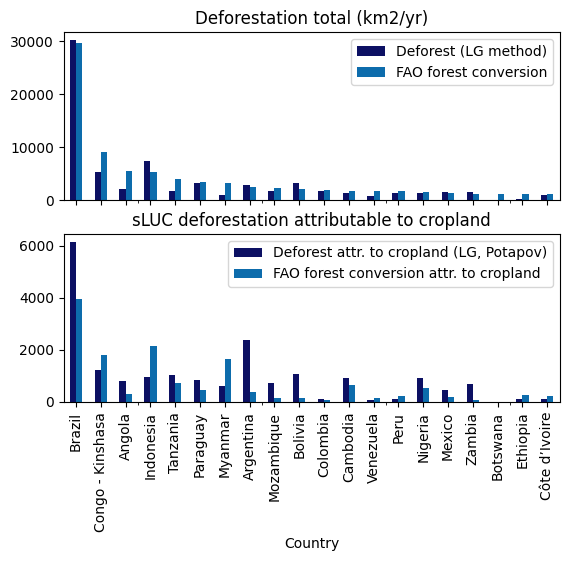

In [8]:
# Comparison of sLUC
c = ["#0c1063", "#0d6cac"]

fig, axs = plt.subplots(2, 1, sharex=True)
title = "Deforestation total (km2/yr)"
cols = {
    "country_name": "Country",
    "deforest": "Deforest (LG method)",
    "fao_forestloss": "FAO forest conversion",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.bar(x="Country", title=title, color=c, ax=axs[0])

title = "sLUC deforestation attributable to cropland"
cols = {
    "country_name": "Country",
    "sluc_deforest_cropland": "Deforest attr. to cropland (LG, Potapov)",
    "sluc_fao_cropland": "FAO forest conversion attr. to cropland",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.bar(x="Country", title=title, color=c, ax=axs[1])
fig.show()

/var/folders/dy/fpsjfhd97fbfjcd25y_m3_8m0000gn/T/ipykernel_78140/2350094979.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


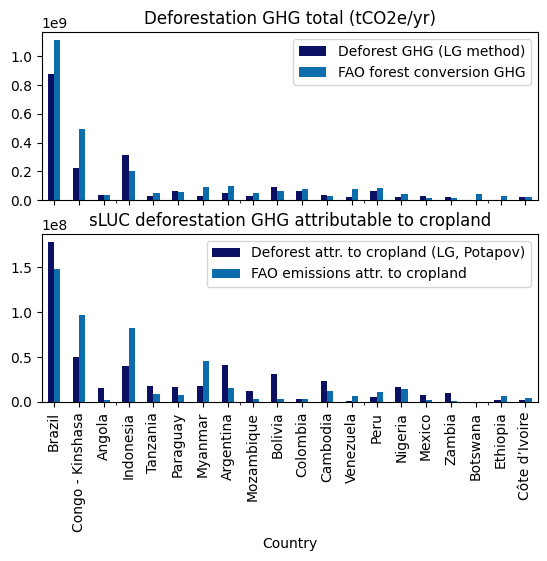

In [ ]:
# Comparison of sLUC
c = ["#0c1063", "#0d6cac"]

fig, axs = plt.subplots(2, 1, sharex=True)
title = "Deforestation GHG total (tCO2e/yr)"
cols = {
    "country_name": "Country",
    "deforest_carbon": "Deforest GHG (LG method)",
    "fao_emissions": "FAO forest conversion GHG",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.bar(x="Country", title=title, color=c, ax=axs[0])

title = "sLUC deforestation GHG attributable to cropland"
cols = {
    "country_name": "Country",
    "sluc_deforest_carbon_cropland": "Deforest attr. to cropland (LG, Potapov)",
    "sluc_emissions_fao_cropland": "FAO emissions attr. to cropland",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.bar(x="Country", title=title, color=c, ax=axs[1])
fig.show()

/var/folders/dy/fpsjfhd97fbfjcd25y_m3_8m0000gn/T/ipykernel_50334/3719744870.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/dy/fpsjfhd97fbfjcd25y_m3_8m0000gn/T/ipykernel_50334/3719744870.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/dy/fpsjfhd97fbfjcd25y_m3_8m0000gn/T/ipykernel_50334/3719744870.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


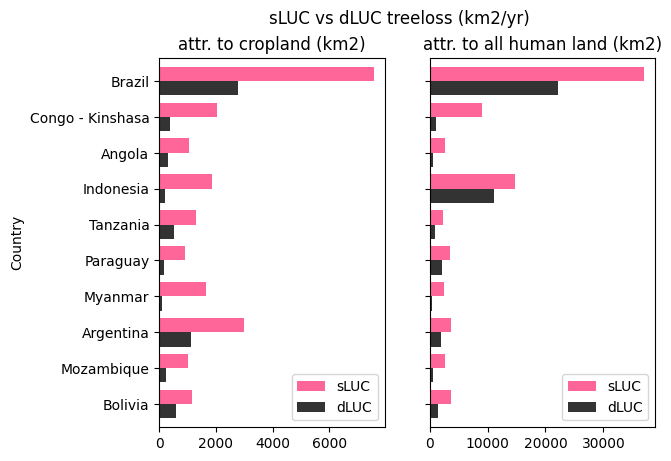

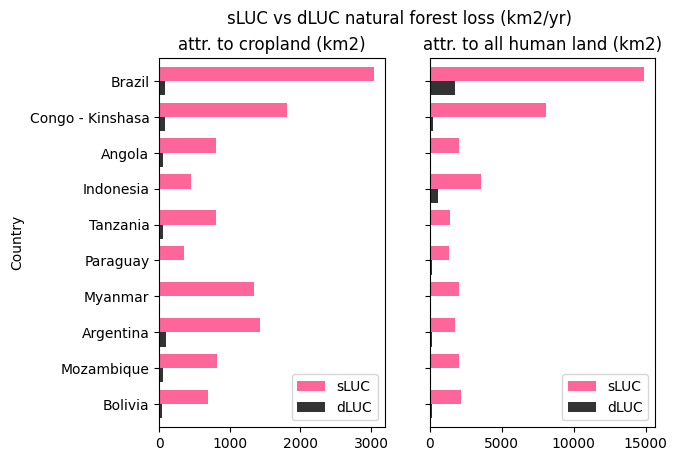

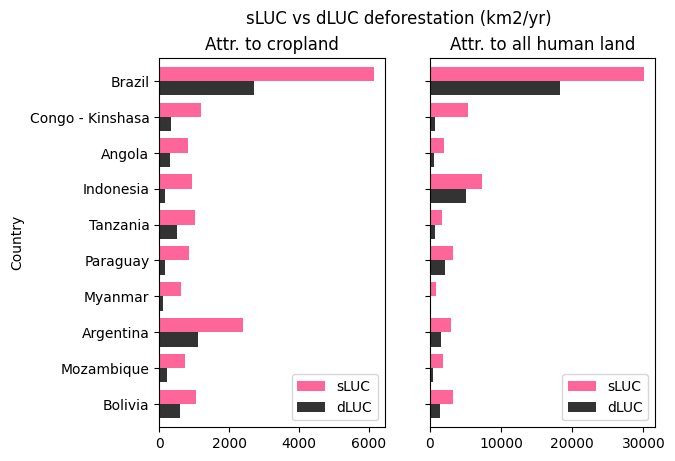

In [11]:
# dLUC
c = ["#fe6598", "#333333"]
N = 10

fig, axs = plt.subplots(1, 2, sharey=True)
fig.suptitle("sLUC vs dLUC treeloss (km2/yr)")
title = "attr. to all human land (km2)"
cols = {
    "country_name": "Country",
    "treeloss": "sLUC",
    "dluc_nonnat_treeloss": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", title=title, color=c, ax=axs[1], width=0.8).invert_yaxis()
title = "attr. to cropland (km2)"
cols = {
    "country_name": "Country",
    "sluc_treeloss_cropland": "sLUC",
    "dluc_cropland_treeloss": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", title=title, color=c, ax=axs[0], width=0.8).invert_yaxis()
fig.show()

fig, axs = plt.subplots(1, 2, sharey=True)
fig.suptitle("sLUC vs dLUC natural forest loss (km2/yr)")
title = "attr. to all human land (km2)"
cols = {
    "country_name": "Country",
    "nat_treeloss": "sLUC",
    "dluc_nonnat_nattreeloss": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", title=title, color=c, ax=axs[1], width=0.8).invert_yaxis()
title = "attr. to cropland (km2)"
cols = {
    "country_name": "Country",
    "sluc_nat_treeloss_cropland": "sLUC",
    "dluc_cropland_nattreeloss": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", title=title, color=c, ax=axs[0], width=0.8).invert_yaxis()
fig.show()

fig, axs = plt.subplots(1, 2, sharey=True)
fig.suptitle("sLUC vs dLUC deforestation (km2/yr)")
title = "Attr. to all human land"
cols = {
    "country_name": "Country",
    "deforest": "sLUC",
    "dluc_nonnat_deforest": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", title=title, color=c, ax=axs[1], width=0.8).invert_yaxis()
title = "Attr. to cropland"
cols = {
    "country_name": "Country",
    "sluc_deforest_cropland": "sLUC",
    "dluc_cropland_deforest": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", title=title, color=c, ax=axs[0], width=0.8).invert_yaxis()
fig.show()

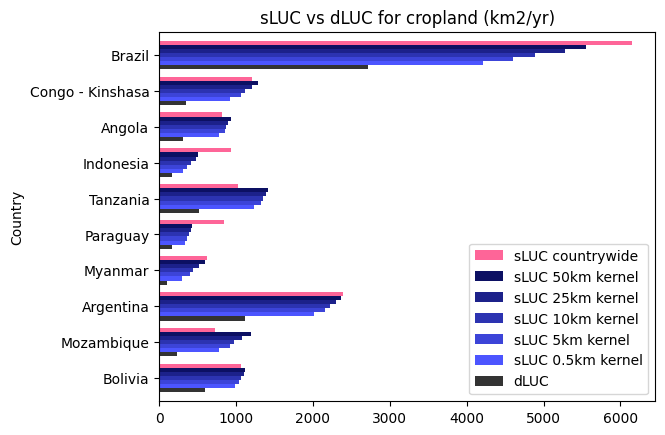

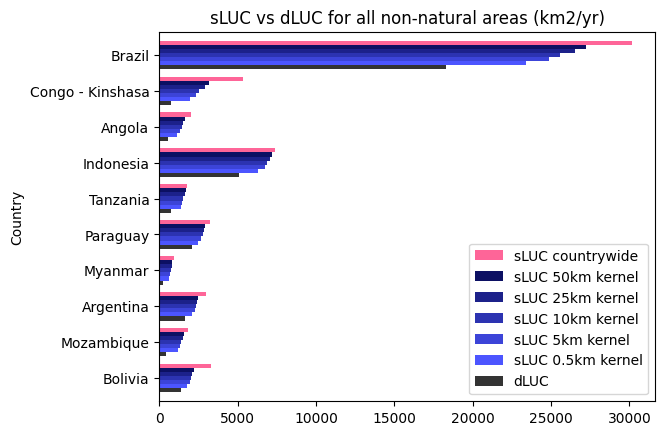

In [12]:
# spatial sLUC

c = ["#fe6598", "#0C1063", "#1C218A", "#2C33B1", "#3C44D8", "#4C55FF", "#333333"]

title = "sLUC vs dLUC for cropland (km2/yr)"
cols = {
    "country_name": "Country",
    "sluc_deforest_cropland": "sLUC countrywide",
    "cropland_deforest_by_human_lu_50km_1000m": "sLUC 50km kernel",
    "cropland_deforest_by_human_lu_25km_1000m": "sLUC 25km kernel",
    "cropland_deforest_by_human_lu_10km_1000m": "sLUC 10km kernel",
    "cropland_deforest_by_human_lu_5km_1000m": "sLUC 5km kernel",
    "cropland_deforest_by_human_lu_0km_1000m": "sLUC 0.5km kernel",
    "dluc_cropland_deforest": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", color=c, title=title, width=0.8).invert_yaxis()


title = "sLUC vs dLUC for all non-natural areas (km2/yr)"
cols = {
    "country_name": "Country",
    "deforest": "sLUC countrywide",
    "nonnat_deforest_by_human_lu_50km_1000m": "sLUC 50km kernel",
    "nonnat_deforest_by_human_lu_25km_1000m": "sLUC 25km kernel",
    "nonnat_deforest_by_human_lu_10km_1000m": "sLUC 10km kernel",
    "nonnat_deforest_by_human_lu_5km_1000m": "sLUC 5km kernel",
    "nonnat_deforest_by_human_lu_0km_1000m": "sLUC 0.5km kernel",
    "dluc_nonnat_deforest": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", color=c, title=title, width=0.8).invert_yaxis()

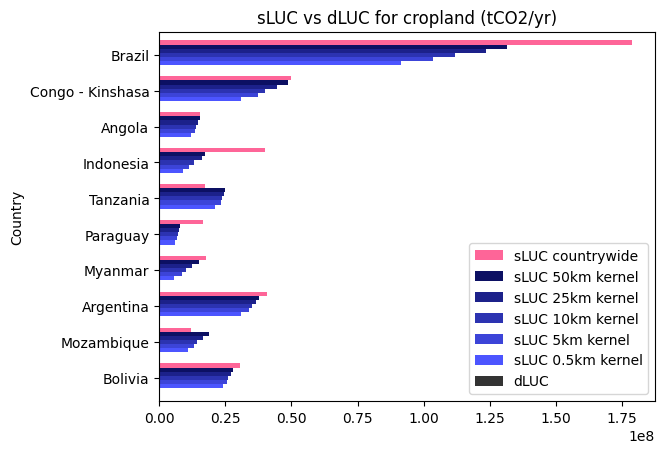

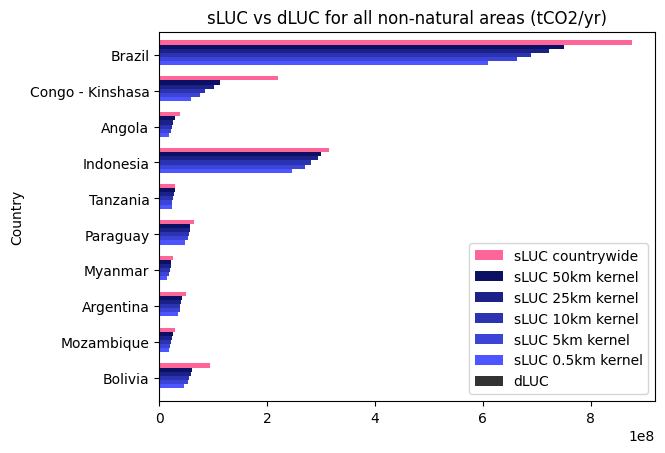

In [13]:
# spatial sLUC

c = ["#fe6598", "#0C1063", "#1C218A", "#2C33B1", "#3C44D8", "#4C55FF", "#333333"]

title = "sLUC vs dLUC for cropland (tCO2/yr)"
cols = {
    "country_name": "Country",
    "sluc_deforest_carbon_cropland": "sLUC countrywide",
    "cropland_deforest_carbon_by_human_lu_50km_1000m": "sLUC 50km kernel",
    "cropland_deforest_carbon_by_human_lu_25km_1000m": "sLUC 25km kernel",
    "cropland_deforest_carbon_by_human_lu_10km_1000m": "sLUC 10km kernel",
    "cropland_deforest_carbon_by_human_lu_5km_1000m": "sLUC 5km kernel",
    "cropland_deforest_carbon_by_human_lu_0km_1000m": "sLUC 0.5km kernel",
    "dluc_cropland_deforest_carbon": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", color=c, title=title, width=0.8).invert_yaxis()


title = "sLUC vs dLUC for all non-natural areas (tCO2/yr)"
cols = {
    "country_name": "Country",
    "deforest_carbon": "sLUC countrywide",
    "nonnat_deforest_carbon_by_human_lu_50km_1000m": "sLUC 50km kernel",
    "nonnat_deforest_carbon_by_human_lu_25km_1000m": "sLUC 25km kernel",
    "nonnat_deforest_carbon_by_human_lu_10km_1000m": "sLUC 10km kernel",
    "nonnat_deforest_carbon_by_human_lu_5km_1000m": "sLUC 5km kernel",
    "nonnat_deforest_carbon_by_human_lu_0km_1000m": "sLUC 0.5km kernel",
    "dluc_nonnat_deforest_carbon": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", color=c, title=title, width=0.8).invert_yaxis()

In [47]:
print("Cropland")
print("Tropical countries")
denom = "sluc_fao_cropland"
denom = "sluc_deforest_cropland"

all_stats_f = all_stats[all_stats[denom] > 0]
all_stats_trop_f = all_stats_trop[all_stats_trop[denom] > 0]

cols = {
    "country_name": "Country",
    "sluc_deforest_cropland": "sLUC countrywide",
    "cropland_deforest_by_human_lu_50km_1000m": "sLUC 50km kernel",
    "cropland_deforest_by_human_lu_25km_1000m": "sLUC 25km kernel",
    "cropland_deforest_by_human_lu_10km_1000m": "sLUC 10km kernel",
    "cropland_deforest_by_human_lu_5km_1000m": "sLUC 5km kernel",
    "cropland_deforest_by_human_lu_0km_1000m": "sLUC 0.5km kernel",
    "dluc_cropland_deforest": "dLUC",
}

for col, lyr in cols.items():
    if col != "country_name":
        print(lyr, round(all_stats_trop_f[col].sum() / all_stats_trop_f[denom].sum(), 3))
print("All countries")
for col, lyr in cols.items():
    if col != "country_name":
        print(lyr, round(all_stats_f[col].sum() / all_stats_f[denom].sum(), 3))

print("All HLU")
print("Tropical countries")
denom = "fao_forestloss"
denom = "deforest"

all_stats_f = all_stats[all_stats[denom] > 0]
all_stats_trop_f = all_stats_trop[all_stats_trop[denom] > 0]


cols = {
    "country_name": "Country",
    "deforest": "sLUC countrywide",
    "nonnat_deforest_by_human_lu_50km_1000m": "sLUC 50km kernel",
    "nonnat_deforest_by_human_lu_25km_1000m": "sLUC 25km kernel",
    "nonnat_deforest_by_human_lu_10km_1000m": "sLUC 10km kernel",
    "nonnat_deforest_by_human_lu_5km_1000m": "sLUC 5km kernel",
    "nonnat_deforest_by_human_lu_0km_1000m": "sLUC 0.5km kernel",
    "dluc_nonnat_deforest": "dLUC",
}

for col, lyr in cols.items():
    if col != "country_name":
        print(lyr, round(all_stats_trop_f[col].sum() / all_stats_trop_f[denom].sum(), 3))
print("All countries")
for col, lyr in cols.items():
    if col != "country_name":
        print(lyr, round(all_stats_f[col].sum() / all_stats_f[denom].sum(), 3))

Cropland
Tropical countries
sLUC countrywide 1.0
sLUC 50km kernel 1.069
sLUC 25km kernel 1.013
sLUC 10km kernel 0.947
sLUC 5km kernel 0.904
sLUC 0.5km kernel 0.793
dLUC 0.379
All countries
sLUC countrywide 1.0
sLUC 50km kernel 0.613
sLUC 25km kernel 0.547
sLUC 10km kernel 0.48
sLUC 5km kernel 0.441
sLUC 0.5km kernel 0.336
dLUC 0.117
All HLU
Tropical countries
sLUC countrywide 1.0
sLUC 50km kernel 0.872
sLUC 25km kernel 0.841
sLUC 10km kernel 0.801
sLUC 5km kernel 0.771
sLUC 0.5km kernel 0.72
dLUC 0.487
All countries
sLUC countrywide 1.0
sLUC 50km kernel 0.78
sLUC 25km kernel 0.74
sLUC 10km kernel 0.691
sLUC 5km kernel 0.65
sLUC 0.5km kernel 0.575
dLUC 0.278


In [45]:
# ALL
# all_stats_f = all_stats_f[~all_stats_f["country_name"].isin(('Canada', 'US'))]
print("ALL COUNTRIES", all_stats_f["fao_forestloss"].count())
print("DEFORESTATION")
print("corr", all_stats_f["fao_forestloss"].corr(all_stats_f["deforest"]))
print(
    "corr nonnat",
    all_stats_f["fao_forestloss"].corr(all_stats_f["nonnat_deforest_by_human_lu_50km_1000m"]),
)
print(
    "corr cropland",
    all_stats_f["sluc_fao_cropland"].corr(all_stats_f["cropland_deforest_by_human_lu_50km_1000m"]),
)
print("this/fao", all_stats_f["deforest"].sum() / all_stats_f["fao_forestloss"].sum())
print(
    "this/fao nonnat",
    all_stats_f["nonnat_deforest_by_human_lu_50km_1000m"].sum()
    / all_stats_f["fao_forestloss"].sum(),
)
print(
    "this/fao cropland",
    all_stats_f["cropland_deforest_by_human_lu_50km_1000m"].sum()
    / all_stats_f["sluc_fao_cropland"].sum(),
)
print("DEFORESTATION TOTALS km2/yr")
print("this", all_stats_f["deforest"].sum())
print("fao", all_stats_f["fao_forestloss"].sum())
print("this cropland", all_stats_f["cropland_deforest_by_human_lu_50km_1000m"].sum())
print("fao cropland", all_stats_f["sluc_fao_cropland"].sum())

print("\n\nCO2")
print("corr", all_stats_f["fao_emissions"].corr(all_stats_f["deforest_carbon"]))
print(
    "corr nonnat",
    all_stats_f["fao_emissions"].corr(all_stats_f["nonnat_deforest_carbon_by_human_lu_50km_1000m"]),
)
print(
    "corr cropland",
    all_stats_f["sluc_emissions_fao_cropland"].corr(
        all_stats_f["cropland_deforest_carbon_by_human_lu_50km_1000m"]
    ),
)
print("this/fao", all_stats_f["deforest_carbon"].sum() / all_stats_f["fao_emissions"].sum())
print(
    "this/fao nonnat",
    all_stats_f["nonnat_deforest_carbon_by_human_lu_50km_1000m"].sum()
    / all_stats_f["fao_emissions"].sum(),
)
print(
    "this/fao cropland",
    all_stats_f["cropland_deforest_carbon_by_human_lu_50km_1000m"].sum()
    / all_stats_f["sluc_emissions_fao_cropland"].sum(),
)

print("CO2 TOTALS tCO2/yr")
print("this", all_stats_f["deforest_carbon"].sum())
print("fao", all_stats_f["fao_emissions"].sum())
print("this cropland", all_stats_f["cropland_deforest_carbon_by_human_lu_50km_1000m"].sum())
print("fao cropland", all_stats_f["sluc_emissions_fao_cropland"].sum())

ALL COUNTRIES 186
DEFORESTATION
corr 0.9732022759291749
corr nonnat 0.9629004645571132
corr cropland 0.7952327912211747
this/fao 0.9156776382684424
this/fao nonnat 0.8096645116478843
this/fao cropland 1.4676452400028432
DEFORESTATION TOTALS km2/yr
this 94612.34608846293
fao 103324.94988888888
this cropland 29184.45523738031
fao cropland 19885.224604635227


CO2
corr 0.962495305847211
corr nonnat 0.9348164991019332
corr cropland 0.8440800980009943
this/fao 0.8286394235186298
this/fao nonnat 0.6870587895393765
this/fao cropland 0.9769685136847832
CO2 TOTALS tCO2/yr
this 2670994144.5992255
fao 3223349105.5222225
this cropland 613129524.9899791
fao cropland 627583710.6330779


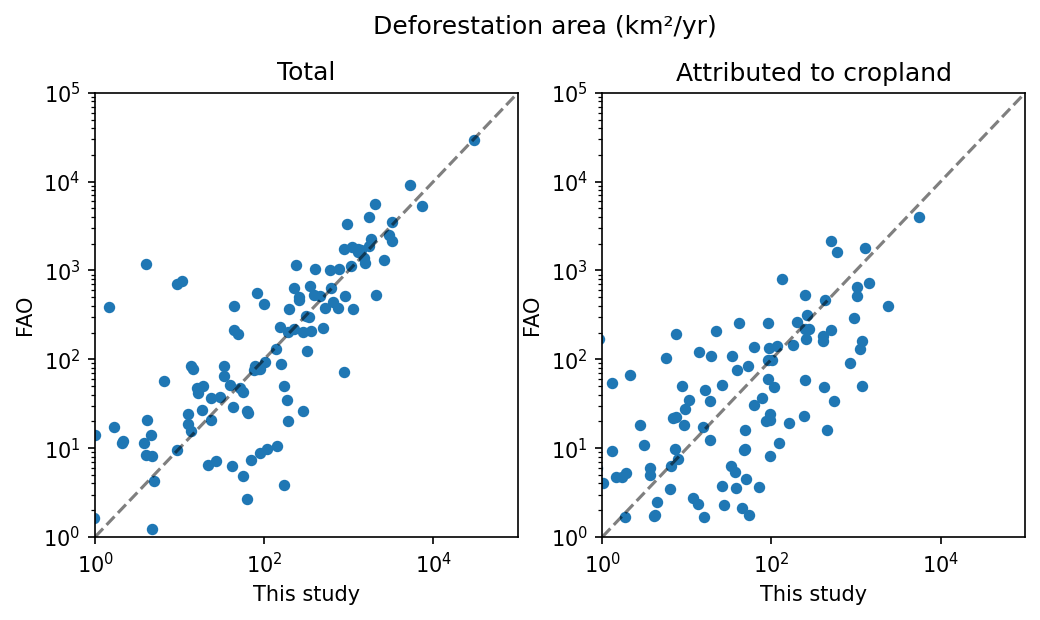

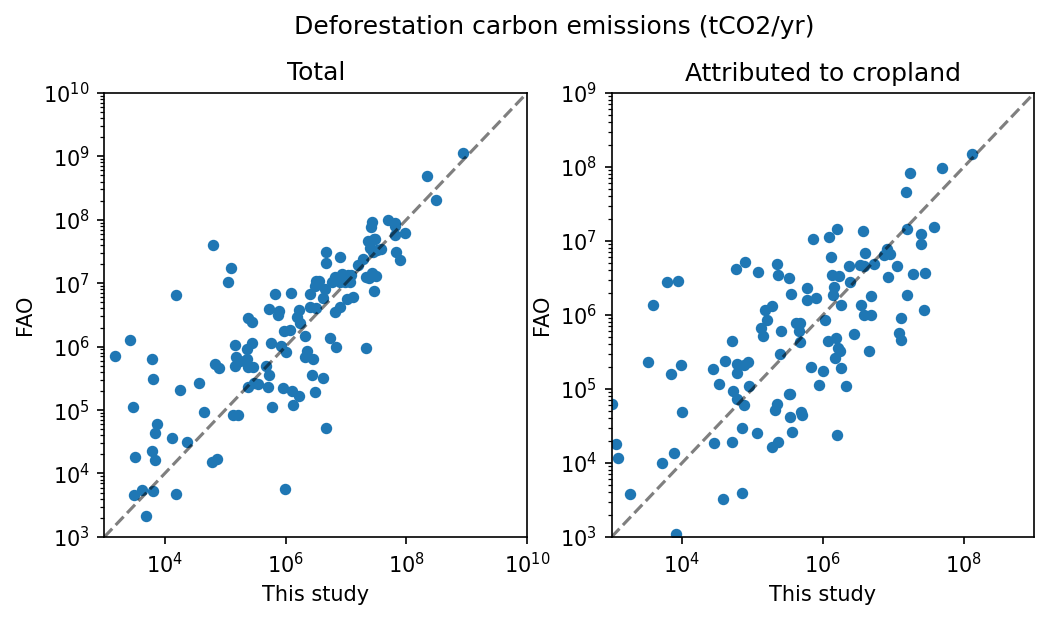

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
fig.suptitle("Deforestation area (km²/yr)")
axs[0].plot([1, 1e5], [1, 1e5], color="k", linestyle="--", alpha=0.5)
axs[1].plot([1, 1e5], [1, 1e5], color="k", linestyle="--", alpha=0.5)
vars = {
    "deforest": "This study",
    "fao_forestloss": "FAO",
}

all_stats_f.filter(vars.keys()).rename(columns=vars).plot(
    ax=axs[0],
    kind="scatter",
    x=list(vars.values())[0],
    y=list(vars.values())[1],
    title="Total",
    loglog=True,
    xlim=[1, 1e5],
    ylim=[1, 1e5],
)
vars = {
    "cropland_deforest_by_human_lu_50km_1000m": "This study",
    "sluc_fao_cropland": "FAO",
}
all_stats_f.filter(vars.keys()).rename(columns=vars).plot(
    ax=axs[1],
    kind="scatter",
    x=list(vars.values())[0],
    y=list(vars.values())[1],
    title="Attributed to cropland",
    loglog=True,
    xlim=[1, 1e5],
    ylim=[1, 1e5],
)
fig.subplots_adjust(top=0.85)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
fig.suptitle("Deforestation carbon emissions (tCO2/yr)")
axs[0].plot([1, 1e10], [1, 1e10], color="k", linestyle="--", alpha=0.5)
axs[1].plot([1, 1e9], [1, 1e9], color="k", linestyle="--", alpha=0.5)
vars = {
    "deforest_carbon": "This study",
    "fao_emissions": "FAO",
}

all_stats_f.filter(vars.keys()).rename(columns=vars).plot(
    ax=axs[0],
    kind="scatter",
    x=list(vars.values())[0],
    y=list(vars.values())[1],
    title="Total",
    loglog=True,
    xlim=[1e3, 1e10],
    ylim=[1e3, 1e10],
)
vars = {
    "cropland_deforest_carbon_by_human_lu_50km_1000m": "This study",
    "sluc_emissions_fao_cropland": "FAO",
}
all_stats_f.filter(vars.keys()).rename(columns=vars).plot(
    ax=axs[1],
    kind="scatter",
    x=list(vars.values())[0],
    y=list(vars.values())[1],
    title="Attributed to cropland",
    loglog=True,
    xlim=[1e3, 1e9],
    ylim=[1e3, 1e9],
)
fig.subplots_adjust(top=0.85)
plt.show()

In [16]:
# TROPICAL
print("TROPICAL COUNTRIES", all_stats_trop_f["fao_forestloss"].count())
print("DEFORESTATION")
print("corr", all_stats_trop_f["fao_forestloss"].corr(all_stats_trop_f["deforest"]))
print(
    "corr nonnat",
    all_stats_trop_f["fao_forestloss"].corr(
        all_stats_trop_f["nonnat_deforest_by_human_lu_50km_1000m"]
    ),
)
print(
    "corr cropland",
    all_stats_trop_f["sluc_fao_cropland"].corr(
        all_stats_trop_f["cropland_deforest_by_human_lu_50km_1000m"]
    ),
)
print("this/fao", all_stats_trop_f["deforest"].sum() / all_stats_trop_f["fao_forestloss"].sum())
print(
    "this/fao nonnat",
    all_stats_trop_f["nonnat_deforest_by_human_lu_50km_1000m"].sum()
    / all_stats_trop_f["fao_forestloss"].sum(),
)
print(
    "this/fao cropland",
    all_stats_trop_f["cropland_deforest_by_human_lu_50km_1000m"].sum()
    / all_stats_trop_f["sluc_fao_cropland"].sum(),
)
print("DEFORESTATION TOTALS km2/yr")
print("this", all_stats_trop_f["deforest"].sum())
print("fao", all_stats_trop_f["fao_forestloss"].sum())
print("this cropland", all_stats_trop_f["cropland_deforest_by_human_lu_50km_1000m"].sum())
print("fao cropland", all_stats_trop_f["sluc_fao_cropland"].sum())

print("\n\nCO2")
print("corr", all_stats_trop_f["fao_emissions"].corr(all_stats_trop_f["deforest_carbon"]))
print(
    "corr nonnat",
    all_stats_trop_f["fao_emissions"].corr(
        all_stats_trop_f["nonnat_deforest_carbon_by_human_lu_50km_1000m"]
    ),
)
print(
    "corr cropland",
    all_stats_trop_f["sluc_emissions_fao_cropland"].corr(
        all_stats_trop_f["cropland_deforest_carbon_by_human_lu_50km_1000m"]
    ),
)
print(
    "this/fao", all_stats_trop_f["deforest_carbon"].sum() / all_stats_trop_f["fao_emissions"].sum()
)
print(
    "this/fao nonnat",
    all_stats_trop_f["nonnat_deforest_carbon_by_human_lu_50km_1000m"].sum()
    / all_stats_trop_f["fao_emissions"].sum(),
)
print(
    "this/fao cropland",
    all_stats_trop_f["cropland_deforest_carbon_by_human_lu_50km_1000m"].sum()
    / all_stats_trop_f["sluc_emissions_fao_cropland"].sum(),
)

print("CO2 TOTALS tCO2/yr")
print("this", all_stats_trop_f["deforest_carbon"].sum())
print("fao", all_stats_trop_f["fao_emissions"].sum())
print("this cropland", all_stats_trop_f["cropland_deforest_carbon_by_human_lu_50km_1000m"].sum())
print("fao cropland", all_stats_trop_f["sluc_emissions_fao_cropland"].sum())

TROPICAL COUNTRIES 118
DEFORESTATION
corr 0.9741197101507476
corr nonnat 0.9639514220468245
corr cropland 0.8098844517075726
this/fao 0.871124119050413
this/fao nonnat 0.7596836319520355
this/fao cropland 1.3676544218993911
DEFORESTATION TOTALS km2/yr
this 85650.52431758428
fao 98321.83777777778
this cropland 24969.326645787358
fao cropland 18257.043772146833


CO2
corr 0.9628697199531697
corr nonnat 0.9349871105683256
corr cropland 0.8543140876899574
this/fao 0.788657090451367
this/fao nonnat 0.64514881035028
this/fao cropland 0.8725935138306302
CO2 TOTALS tCO2/yr
this 2468422124.9320436
fao 3129905449.172222
this cropland 523896829.09233797
fao cropland 600390469.088481


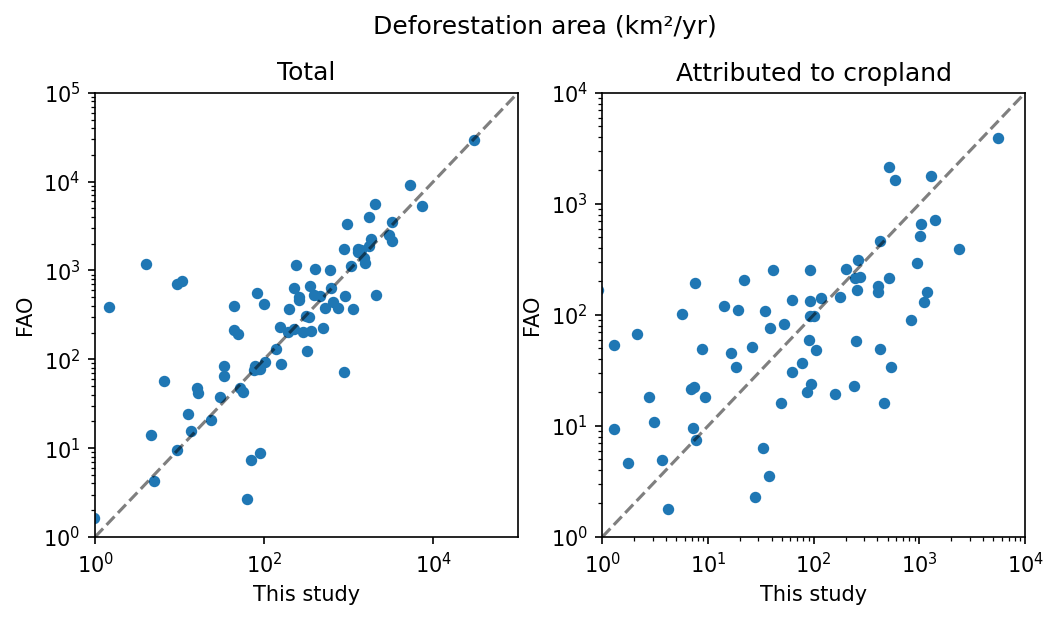

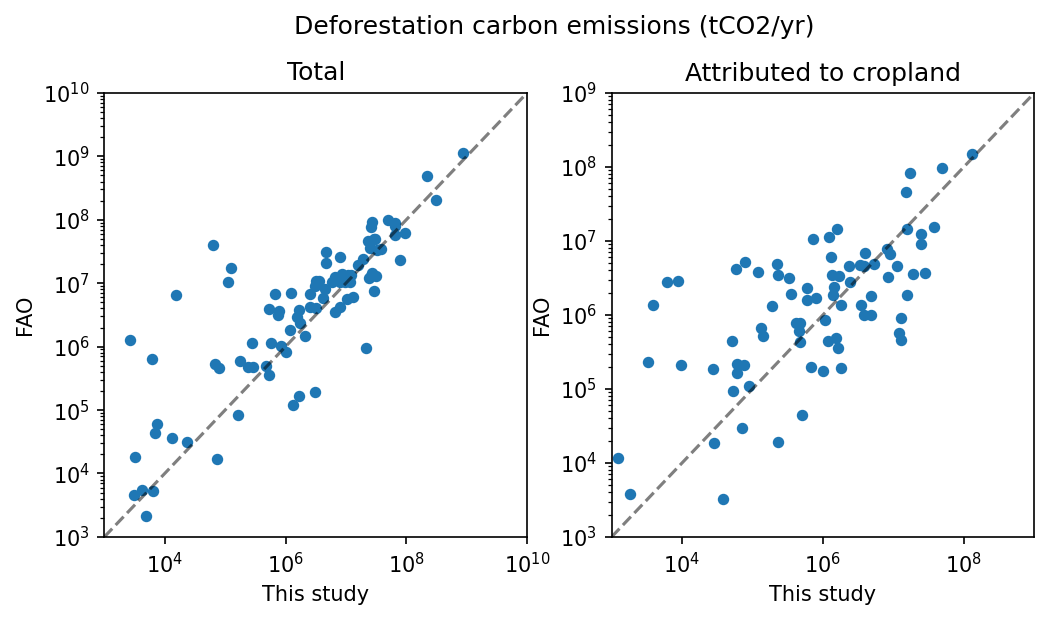

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
fig.suptitle("Deforestation area (km²/yr)")
axs[0].plot([1, 1e5], [1, 1e5], color="k", linestyle="--", alpha=0.5)
axs[1].plot([1, 1e4], [1, 1e4], color="k", linestyle="--", alpha=0.5)
vars = {
    "deforest": "This study",
    "fao_forestloss": "FAO",
}

all_stats_trop_f.filter(vars.keys()).rename(columns=vars).plot(
    ax=axs[0],
    kind="scatter",
    x=list(vars.values())[0],
    y=list(vars.values())[1],
    title="Total",
    loglog=True,
    xlim=[1, 1e5],
    ylim=[1, 1e5],
)
vars = {
    "cropland_deforest_by_human_lu_50km_1000m": "This study",
    "sluc_fao_cropland": "FAO",
}
all_stats_trop_f.filter(vars.keys()).rename(columns=vars).plot(
    ax=axs[1],
    kind="scatter",
    x=list(vars.values())[0],
    y=list(vars.values())[1],
    title="Attributed to cropland",
    loglog=True,
    xlim=[1, 1e4],
    ylim=[1, 1e4],
)
fig.subplots_adjust(top=0.85)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
fig.suptitle("Deforestation carbon emissions (tCO2/yr)")
axs[0].plot([1, 1e10], [1, 1e10], color="k", linestyle="--", alpha=0.5)
axs[1].plot([1, 1e9], [1, 1e9], color="k", linestyle="--", alpha=0.5)
vars = {
    "deforest_carbon": "This study",
    "fao_emissions": "FAO",
}

all_stats_trop_f.filter(vars.keys()).rename(columns=vars).plot(
    ax=axs[0],
    kind="scatter",
    x=list(vars.values())[0],
    y=list(vars.values())[1],
    title="Total",
    loglog=True,
    xlim=[1e3, 1e10],
    ylim=[1e3, 1e10],
)
vars = {
    "cropland_deforest_carbon_by_human_lu_50km_1000m": "This study",
    "sluc_emissions_fao_cropland": "FAO",
}
all_stats_trop_f.filter(vars.keys()).rename(columns=vars).plot(
    ax=axs[1],
    kind="scatter",
    x=list(vars.values())[0],
    y=list(vars.values())[1],
    title="Attributed to cropland",
    loglog=True,
    xlim=[1e3, 1e9],
    ylim=[1e3, 1e9],
)
fig.subplots_adjust(top=0.85)
plt.show()

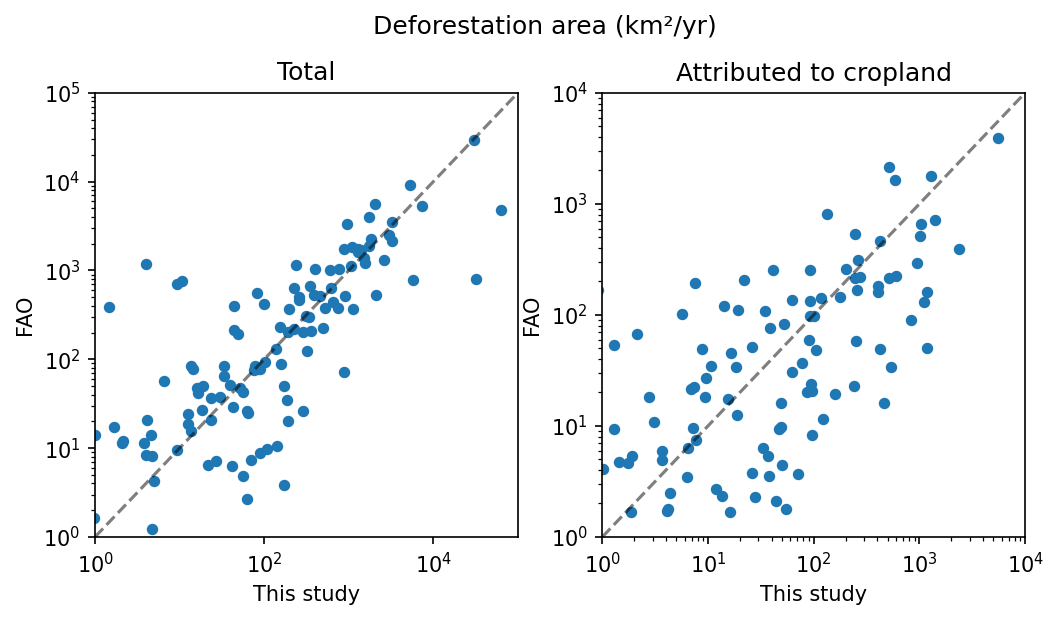

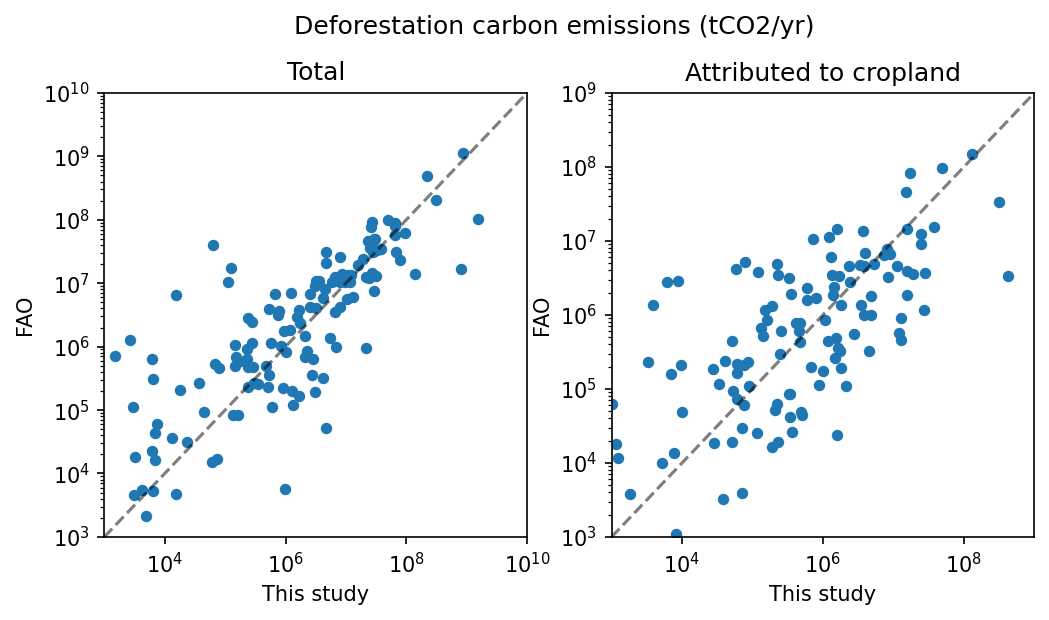

In [ ]:
all_stats_trop_f.count()

system:index                      126
ADM0_NAME                         126
DISP_AREA                         126
EXP0_YEAR                         126
STATUS                            126
                                 ... 
sluc_fao_cropland                 117
sluc_emissions_fao_agland_ha      117
sluc_emissions_fao_cropland_ha    117
sluc_emissions_fao_cropland       117
fao_ratio                         118
Length: 100, dtype: int64